In [53]:
import numpy 
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from skimage import transform

In [24]:
image_dim = (320, 320, 3)
image_dir = '../Datasets/SIDD_Small_sRGB_Only/'
orig_image = 'GT_SRGB_010.PNG'
noisy_image = 'NOISY_SRGB_010.PNG'

In [25]:
# Get the image paths

import os
import cv2
from PIL import Image

fileslist = [] # all file names
def read_filepath(path = image_dir + 'Scene_Instances.txt'):
    with open(path) as my_file:
        for line in my_file:
            fileslist.append(line.strip())

read_filepath()
len(fileslist)

160

In [26]:
df = pd.DataFrame({'file':fileslist})
df.head()

,file
0,0001_001_S6_00100_00060_3200_L
1,0002_001_S6_00100_00020_3200_N
2,0003_001_S6_00100_00060_3200_H
3,0004_001_S6_00100_00060_4400_L
4,0005_001_S6_00100_00060_4400_N


In [27]:
# Data Loaders
import tensorflow.keras as keras
from scipy.interpolate import interp1d
import numpy as np
from scipy.ndimage.interpolation import rotate, shift
from PIL import Image

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data_frame, batch_size=16, dim=image_dim, data_mean=0, data_std=1,  data_prefix='', shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.data_frame = data_frame
        self.image_label = data_frame['file'].values.tolist()
        self.image_ids = np.arange(len(self.image_label)).tolist()
        self.data_prefix = data_prefix
        self.data_mean = data_mean
        self.data_std = data_std
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.image_ids) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        data_ids_temp = [self.image_ids[k] for k in indexes]
        X, Y = self.__data_generation(data_ids_temp)
        
        return X, Y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.image_ids))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __data_generation(self, data_ids_temp):
        'Generates data containing batch_size samples' 
        X = np.empty((self.batch_size, *self.dim))
        Y = np.empty((self.batch_size, *self.dim))
        
        for i, ids in enumerate(data_ids_temp):
            X[i,], Y[i,] = self.__read_data_instance(data_ids_temp[i])
        return X, Y


    def __read_data_instance(self, pid):
        

        input_image = Image.open(image_dir + 'Data/' + self.data_frame.iloc[pid]['file'] + '/' + noisy_image)
        input_image = input_image.resize((320,320))
        
        output_image = Image.open(image_dir + 'Data/' + self.data_frame.iloc[pid]['file'] + '/' + orig_image)
        output_image = input_image.resize((320,320))
        
        input_image = np.asarray(input_image)
        output_image = np.asarray(output_image)

        X = input_image
        Y = output_image

        # Input normalization
        
        X = (X - self.data_mean)/self.data_std
        Y = (Y - self.data_mean)/self.data_std

        return X, Y

/var/folders/5r/lf9pn80n3v94lqfn0rhbsd6r0000gn/T/ipykernel_1438/835431613.py:5: DeprecationWarning: Please use `rotate` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import rotate, shift
/var/folders/5r/lf9pn80n3v94lqfn0rhbsd6r0000gn/T/ipykernel_1438/835431613.py:5: DeprecationWarning: Please use `shift` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import rotate, shift


In [28]:
# Split dataframe stratify shape
df_train, df_test_valid = train_test_split(df, test_size=0.2, random_state=101)
df_valid, df_test = train_test_split(df_test_valid, test_size=0.35, random_state=101)

In [73]:
BATCH_SIZE_TRAIN = 4
BATCH_SIZE_VALID = 4
BATCH_SIZE_TEST = 1

data_mean = 0.
data_std = 255.0
prefix=''

training_generator = DataGenerator(df_train, batch_size=BATCH_SIZE_TRAIN, data_mean=data_mean, data_std=data_std, shuffle=True, data_prefix=prefix)
validation_generator = DataGenerator(df_valid, batch_size=BATCH_SIZE_VALID, data_mean=data_mean, data_std=data_std, shuffle=True, data_prefix=prefix)
test_generator = DataGenerator(df_test, batch_size=BATCH_SIZE_TEST, data_mean=data_mean, data_std=data_std, shuffle=False, data_prefix=prefix)

In [40]:
print(training_generator.__len__())
count = 0
for x,y in training_generator.__iter__():
    count += 1
    print(x.shape, y.shape)
    if count == 5:
        break

32
(4, 320, 320, 3) (4, 320, 320, 3)
(4, 320, 320, 3) (4, 320, 320, 3)
(4, 320, 320, 3) (4, 320, 320, 3)
(4, 320, 320, 3) (4, 320, 320, 3)
(4, 320, 320, 3) (4, 320, 320, 3)


/var/folders/5r/lf9pn80n3v94lqfn0rhbsd6r0000gn/T/ipykernel_1438/4230254284.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


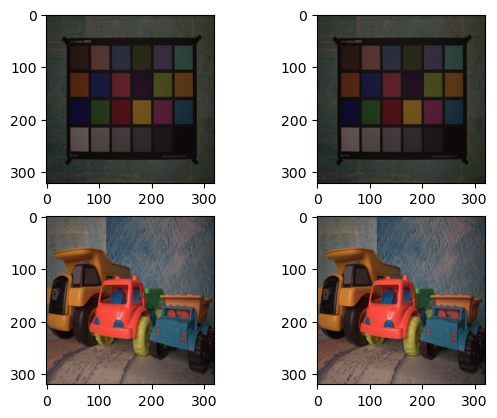

In [42]:
x, y = training_generator.__getitem__(0)
f, ax = plt.subplots(2,2)
ax[0,0].imshow(x[0])
ax[0,1].imshow(y[0])
ax[1,0].imshow(x[1])
ax[1,1].imshow(y[1])
f.show()

In [43]:
x[0].min(), x[0].max()

(0.011764705882352941, 0.4666666666666667)

#### Model

In [44]:
# The encoder

x = tf.keras.layers.Input(shape=image_dim)
x_e = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
# x_e = tf.keras.layers.Dropout(0.2)(x_e)
x_e = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x_e)
x_e = tf.keras.layers.BatchNormalization()(x_e)
x_e = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x_e)
# x_e = tf.keras.layers.Dropout(0.2)(x_e)
x_e = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x_e)
x_e = tf.keras.layers.BatchNormalization()(x_e)
# x_e = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x_e)
#x_e = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x_e)

In [45]:
# The decoder

x_d = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x_e)
# x_e = tf.keras.layers.Dropout(0.2)(x_e)
x_d = tf.keras.layers.UpSampling2D((2, 2))(x_d)
x_d = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x_d)
# x_e = tf.keras.layers.Dropout(0.2)(x_e)
x_d = tf.keras.layers.UpSampling2D((2, 2))(x_d)
x_d = tf.keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x_d)

In [46]:
model = tf.keras.Model(x, x_d)
model.compile(optimizer='adam', loss='mse')

In [47]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 320, 320, 3)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 320, 320, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 160, 160, 16)     0         
 2D)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 160, 160, 16)     64        
 hNormalization)                                                 
                                                                 
 conv2d_6 (Conv2D)           (None, 160, 160, 32)      4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 80, 80, 32)       0   

In [48]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
history = model.fit(training_generator, validation_data=validation_generator, epochs=10, batch_size=4, callbacks=[early_stop])

Epoch 1/10


2022-12-11 01:56:31.615505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - ETA: 0s - loss: 0.0303

2022-12-11 01:57:15.538505: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 50s 2s/step - loss: 0.0303 - val_loss: 0.0794
Epoch 2/10
32/32 [==============================] - 49s 2s/step - loss: 0.0152 - val_loss: 0.0569
Epoch 3/10
32/32 [==============================] - 49s 2s/step - loss: 0.0158 - val_loss: 0.0562
Epoch 4/10
32/32 [==============================] - 49s 2s/step - loss: 0.0151 - val_loss: 0.0384
Epoch 5/10
32/32 [==============================] - 49s 2s/step - loss: 0.0121 - val_loss: 0.0300
Epoch 6/10
32/32 [==============================] - 49s 2s/step - loss: 0.0145 - val_loss: 0.0259
Epoch 7/10
32/32 [==============================] - 49s 2s/step - loss: 0.0111 - val_loss: 0.0278
Epoch 8/10
32/32 [==============================] - 50s 2s/step - loss: 0.0117 - val_loss: 0.0237
Epoch 9/10
32/32 [==============================] - 50s 2s/step - loss: 0.0101 - val_loss: 0.0232
Epoch 10/10
32/32 [==============================] - 49s 2s/step - loss: 0.0090 - val_loss: 0.0177


In [74]:
result = model.predict(test_generator)
model.evaluate(test_generator)

12/12 [==============================] - 4s 319ms/step - loss: 0.0148


0.01482756994664669

In [65]:
def getprediction(model = model, dataframe = df_train, image_dir = image_dir):
    image_dim = (320,320,3)
    predLabels = []
    def load_all(filename, location):
        np_image = Image.open(filename)
        np_image = np.array(np_image).astype('float32')
        np_image = transform.resize(np_image, image_dim)
        np_image = np.expand_dims(np_image, axis=0)
        #np_image = preprocess_input(np_image)
        return np_image

    for i in range(0, len(dataframe) - 8):
        fig, ax = plt.subplots(1, 11)
        print('Test images with noises')
        input_img = load_all(image_dir  + 'Data/' + dataframe.iloc[i]['file'] + '/' + noisy_image, i)
        plt.subplot(1,4,i+1)
        plt.imshow(image_dir  + 'Data/' + dataframe.iloc[i]['file'] + '/' + noisy_image)

/var/folders/5r/lf9pn80n3v94lqfn0rhbsd6r0000gn/T/ipykernel_1438/3134549058.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


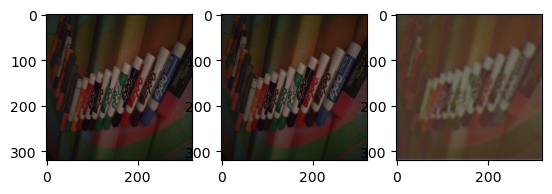

In [81]:
x, y = test_generator.__getitem__(3)
f, ax = plt.subplots(1,3)
ax[0].imshow(x[0])
ax[1].imshow(y[0])
ax[2].imshow(result[3])
f.show()